In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

### Постановка задачи

Для изображения, состоящего из дорожного знака, спрогнозировать ограничивающую рамку вокруг дорожного знака и определить тип дорожного знака.
Эти знаки могут принадлежать четырем различным классам:  
* Светофор
* Стоп
* Ограничение скорости
* Пешеходный переход

Это называется многозадачная задача обучения, поскольку она включает в себя выполнение двух задач: 
1) регрессия для нахождения координат bounding box'a,   
2) классификация для определения типа дорожного знака. 

### Датасет

Он состоит из 877 изображений. Это довольно несбалансированный набор данных, большинство изображений относится к классу ограничение скорости, но, поскольку мы больше сосредоточены на прогнозировании ограничивающей рамки, мы можем игнорировать дисбаланс.

### Загрузка данных

Описания для каждого изображения хранятся в отдельных файлах XML. Сделаем следующие шаги для подготовки данных для тренировки:  
* Пройдемся по директории annotations что бы получить все файлы .xml
* Прочитаем нужную нам информацию из каждого файла .xml используя xml.etree.ElementTree
* Создадим словарь содержащий filepath(путь до картинки), width, height, (xmin , xmax , ymin , ymax) (кординаты bounding box'a) и class и добавим словарь в список.
* Создадим pandas dataframe используя список словарей из прошлого пункта

In [2]:
images_path = Path('./road_sign_detection_input/images')
anno_path = Path('./road_sign_detection_input/annotations')

def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name,
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [3]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,road_sign_detection_input\images\road0.png,267,400,trafficlight,98,62,208,232
1,road_sign_detection_input\images\road1.png,400,283,trafficlight,154,63,258,281
2,road_sign_detection_input\images\road10.png,400,267,trafficlight,106,3,244,263
3,road_sign_detection_input\images\road100.png,400,385,speedlimit,35,5,363,326
4,road_sign_detection_input\images\road101.png,400,200,speedlimit,195,7,392,194
...,...,...,...,...,...,...,...,...
872,road_sign_detection_input\images\road95.png,300,400,stop,90,101,268,257
873,road_sign_detection_input\images\road96.png,400,267,stop,209,58,326,179
874,road_sign_detection_input\images\road97.png,400,267,stop,42,66,130,154
875,road_sign_detection_input\images\road98.png,400,267,stop,138,17,376,245


In [4]:
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64

Преобразуем наши метки в классы:


In [5]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,road_sign_detection_input\images\road0.png,267,400,3,98,62,208,232
1,road_sign_detection_input\images\road1.png,400,283,3,154,63,258,281
2,road_sign_detection_input\images\road10.png,400,267,3,106,3,244,263
3,road_sign_detection_input\images\road100.png,400,385,0,35,5,363,326
4,road_sign_detection_input\images\road101.png,400,200,0,195,7,392,194


### Изменение размеров изображений и bounding box'ов

Поскольку для обучения модели компьютерного зрения изображения должны иметь одинаковый размер, нам необходимо изменить размер наших изображений и соответствующих им ограничивающих рамок. Изменить размер изображения просто, но изменить размер bounding box'a немного сложнее, потому что каждый прямоугольник зависит от изображения и его размеров.

Вот основаная идея:

Преобразуем bounding box в изображение(маску) того же размера что и соотвествующее этому прямоугольнику изображение. Эта маска будет просто иметь 0 для заднего фона и 1 для области покрывающей bounding box.

Сначала прочитаем изображение:

In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)


def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)


Применим все наши написанные функции:

In [7]:
IM_SIZE = 300

In [8]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,road_sign_detection_input\images\road0.png,267,400,3,98,62,208,232,images_resized\road0.png,"[46.0, 110.0, 173.0, 233.0]"
1,road_sign_detection_input\images\road1.png,400,283,3,154,63,258,281,images_resized\road1.png,"[66.0, 115.0, 297.0, 193.0]"
2,road_sign_detection_input\images\road10.png,400,267,3,106,3,244,263,images_resized\road10.png,"[3.0, 79.0, 295.0, 182.0]"
3,road_sign_detection_input\images\road100.png,400,385,0,35,5,363,326,images_resized\road100.png,"[4.0, 26.0, 253.0, 272.0]"
4,road_sign_detection_input\images\road101.png,400,200,0,195,7,392,194,images_resized\road101.png,"[10.0, 146.0, 291.0, 293.0]"


### Пример получившегося сэмпла


(293, 400, 3)


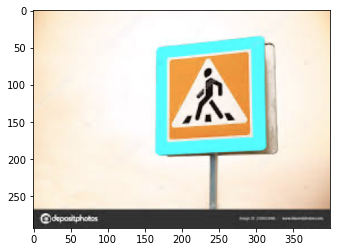

In [9]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)

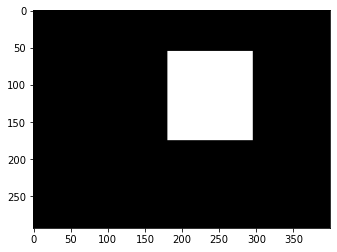

In [10]:
plt.imshow(Y, cmap='gray')

### Аугментация данных

Аугментация данных - это метод, позволяющий лучше обобщить нашу модель путем создания новых обучающих изображений с использованием различных вариантов существующих изображений. В нашем текущем обучающем наборе всего 800 изображений, поэтому увеличение данных очень важно, чтобы наша модель не переобучилась.  
Для этой задачи будем использовать переворот, поворот, центральную обрезку и случайную обрезку.

Единственное, что здесь нужно помнить, - это убедиться, что ограничивающая рамка также трансформируется так же, как и изображение. Для этого мы следуем тому же подходу, что и изменение размера - преобразуем ограничивающую рамку в маску, применяем те же преобразования к маске, что и исходное изображение, и извлекаем координаты ограничивающей рамки.

In [11]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

### Пример изображения 

Оригинал:


images_resized\road139.png


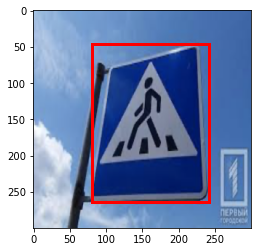

In [12]:
number = 45
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])


После трансформации:

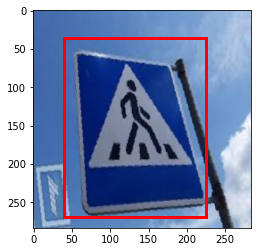

In [13]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

### Датасет

Теперь, когда у нас есть дополнения к данным, мы можем создать набор данных PyTorch. Мы нормализуем изображения с помощью статистики ImageNet, потому что мы будем использовать предварительно обученную модель ResNet и применим аугментацию данных в нашем наборе данных во время обучения.


In [49]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

ValueError: cannot insert level_0, already exists


Загрузим все это в наш даталоадер:


In [15]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)


### Определение модели

В качестве модели мы будем использовать очень простую предварительно обученную модель [resNet-34](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet34). Поскольку здесь у нас есть две задачи, есть два последних слоя - регрессия ограничивающей рамки и классификатор изображений.


In [16]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [17]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

### Обучение

Для расчета потерь нам нужно принять во внимание как потерю классификации, так и потерю регрессии ограничивающего прямоугольника, поэтому мы используем комбинацию кросс-энтропии и L1-потери (сумма всех абсолютных различий между истинным значением и прогнозируемыми координатами).

In [18]:
model = BB_model() # no cuda .cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.006)
epochs = 15
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [19]:
def train():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.float() # .cuda().float()
            y_class = y_class # no cuda .cuda()
            y_bb = y_bb.float() # no cudaaa .cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.float() # .cuda().float()
            y_class = y_class # no cudaaaaa .cuda()
            y_bb = y_bb.float() # .cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}", flush=True)

In [20]:
# train()


Трюк: мы можем после прохождения обучения изменить шаг обучения и продолжить:



In [21]:
for i, param_group in enumerate(optimizer.param_groups):
    param_group["lr"] = 0.001

In [22]:
# train()
model = torch.load('sign_detection_weights.pt')


# Тестирование

In [42]:
# resizing test image
im = read_image('./images_resized/road3.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road3.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [43]:
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':'./road_signs_test/road3.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 284])

In [44]:
# prediction
out_class, out_bb = model(xx) # no cuda .cuda())
out_class, out_bb

(tensor([[-0.8652,  0.2698,  0.3987,  2.3843]], grad_fn=<AddmmBackward0>),
 tensor([[ 65.5356,  41.7017, 289.0820, 244.3310]], grad_fn=<AddmmBackward0>))

In [45]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([2.3843], grad_fn=<MaxBackward0>),
indices=tensor([3]))

In [46]:
class_dict

{'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}

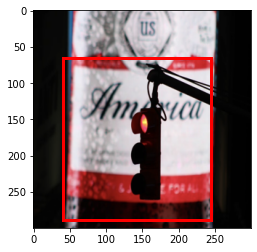

In [47]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [29]:
# torch.save(model, 'sign_detection_weights.pt')